# Analiza sentymentu na podstawie zbioru danych Ermlab Opineo dataset- opineo reviews (https://drive.google.com/file/d/1vXqUEBjUHGGy3vV2dA7LlvBjjZlQnl0D/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install texthero
!pip install livelossplot
!pip install pyLDAvis
!pip install -U spacy
!python -m spacy download pl_core_news_sm

     |████████████████████████████████| 1.4MB 14.2MB/s 
     |████████████████████████████████| 245kB 51.0MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434676 sha256=11772ea69b019f7c3412ac60747d6829d9e1b9847d19abdeb844e8d60b29ceba
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 1.7MB 7.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=38aa91f7aa10448f92c5940f0d3e098791fed53acef0544e0beb93a4c5518211
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis
     |████████████████████████████████| 12.7MB 250kB/s 
     |████████████████████████████████| 9.1MB 51.1MB/s 
     |██████████████████████████████

In [ ]:
import numpy as np
import pandas as pd

import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing import sequence
from livelossplot import PlotLossesKeras

import texthero as hero
import spacy

from gensim.utils import simple_preprocess
import gensim
from gensim import corpora, models
import pyLDAvis.gensim as gensimvis
import pyLDAvis

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pl_core_news_sm

from collections import Counter

## Przygoowanie danych

In [ ]:
data_dir = './drive/My Drive/Colab Notebooks/pko/polish_sentiment_dataset.csv'

In [ ]:
df = pd.read_csv(data_dir)
df.shape

(936883, 3)

In [ ]:
df['rate'].value_counts(normalize=True)

 1.0    0.783771
-1.0    0.196431
 0.0    0.019798
Name: rate, dtype: float64

In [ ]:
df[df['rate'] == 0.0].head()

description  length  rate
3             0     0.0   0.0
16            0     0.0   0.0
34            0     0.0   0.0
76            0     0.0   0.0
131           0     0.0   0.0

In [ ]:
df[(df['rate'] == 0.0) & (df['description'] != '0') & (df['length'] != 0.0)].shape

(0, 3)

In [ ]:
df = df[(df['rate'] != 0.0) & (df['description'] != '0') & (df['length'] != 0.0) & (df['description'].isnull() == False) & (df['rate'].isnull() == False)]
df.shape

(917641, 3)

In [ ]:
df['rate'].value_counts(normalize=True)

 1.0    0.80015
-1.0    0.19985
Name: rate, dtype: float64

In [ ]:
df_pos = df[df['rate'] == 1.0]
df_pos.shape

(734250, 3)

In [ ]:
df_neg = df[df['rate'] == -1.0]
df_neg.shape

(183391, 3)

In [ ]:
df_pos_sample = df_pos.sample(9600, random_state=0)
df_pos_sample.head()

description  length  rate
607741  Transakcja przebiegła pomyslnie. Doceniam term...   104.0   1.0
651438        Wszystko ok. Szybko, zgodnie z zamówieniem.    43.0   1.0
522456           Miła obsługa . Polecam tego sprzedawcę .    40.0   1.0
267897        Szybka i bezproblemowa transakcja, polecam.    43.0   1.0
585890  bardzo przyjemnmie sie robilo zakupy.szybka do...   307.0   1.0

In [ ]:
df_pos_sample.shape

(9600, 3)

In [ ]:
df_pos_train, df_pos_test = train_test_split(df_pos_sample, test_size=0.15, random_state=0)

df_pos_train.shape, df_pos_test.shape

((8160, 3), (1440, 3))

In [ ]:
df_pos_train.head()

description  length  rate
353033        Polecam. Towar zgodny z opisem. Dostawa ok.    43.0   1.0
266100                    Szybko i bez problemów, polecam    31.0   1.0
618889       Szybka i rzetelna obsługa. Polecam kupującym    44.0   1.0
309460  Pozytywna. Wszystkie zamówienia realizowane rz...    89.0   1.0
615591             Wszystko szybko, super i bez problemów    38.0   1.0

In [ ]:
df_neg_sample = df_neg.sample(2400, random_state=0)
df_neg_sample.head()

description  length  rate
913826                          Zesikałam się ze śmiechu      NaN  -1.0
794011                        kto ogląda po końcu świata      NaN  -1.0
860248             Chyba jednak posłycham głebokie gardło     NaN  -1.0
880145                           Gdzie te kurwy mieszkają     NaN  -1.0
904410  Bracia Pierdolec i Siostry Pierdolecz czyżby m...     NaN  -1.0

In [ ]:
df_neg_sample.shape

(2400, 3)

In [ ]:
df_neg_train, df_neg_test = train_test_split(df_neg_sample, test_size=0.15, random_state=0)

df_neg_train.shape, df_neg_test.shape

((2040, 3), (360, 3))

In [ ]:
df_neg_train.head()

description  length  rate
880066  Oglądanie obcinania głowy nożem na sadistic ta...     NaN  -1.0
864493                        bez wahania użył bym broni      NaN  -1.0
882558                     Gdzie nastolatkowie mają mózg      NaN  -1.0
800435     to niezła sowa, ja bym odkeciał na jej mjejscu     NaN  -1.0
854132                          224 jebla sie o barierke      NaN  -1.0

## Zbiór treningowy

In [ ]:
df_new_train = pd.concat([df_pos_train, df_neg_train])
df_new_train.shape

(10200, 3)

In [ ]:
df_train = df_new_train.sample(frac=1, random_state=0)
df_train.head()

description  length  rate
500132        Polecam ! Szybko, solidnie ,bez problemów !    43.0   1.0
709189  wszystko super, ekspresowa przesylka, towar zg...    59.0   1.0
329199  Profesjonalna obsługa, szybka dostawa, jak naj...    82.0   1.0
920006  Dobrze wam radzę przestańcie śpiewać, bo ludzi...     NaN  -1.0
325795  Bardzo szybka realizacja zamówienia. Ceny niżs...    71.0   1.0

In [ ]:
df_train['rate'] = df_train['rate'].apply(lambda x: int(x) if x == 1.0 else 0)
df_train = df_train.reset_index()
df_train.head()

index                                        description  length  rate
0  500132        Polecam ! Szybko, solidnie ,bez problemów !    43.0     1
1  709189  wszystko super, ekspresowa przesylka, towar zg...    59.0     1
2  329199  Profesjonalna obsługa, szybka dostawa, jak naj...    82.0     1
3  920006  Dobrze wam radzę przestańcie śpiewać, bo ludzi...     NaN     0
4  325795  Bardzo szybka realizacja zamówienia. Ceny niżs...    71.0     1

## Zbiór testowy

In [ ]:
df_new_test = pd.concat([df_pos_test, df_neg_test])
df_new_test.shape

(1800, 3)

In [ ]:
df_test = df_new_test.sample(frac=1, random_state=0)
df_test.head()

description  length  rate
544259  Profesjonalna obsługa, błyskawiczna dostawa, p...    73.0   1.0
755331  Trzeci zakup w sklepie i wszystko poszło jak t...   170.0   1.0
189996  pierwsza wysyłka trochę opóźniona, ale chyba z...   214.0   1.0
672029  POLECAM, poważnie traktują klienta. Wszystko n...    52.0   1.0
863796  głębokie gardło  tak to my, ale teledysk fajny...     NaN  -1.0

In [ ]:
df_test['rate'] = df_test['rate'].apply(lambda x: int(x) if x == 1.0 else 0)
df_test = df_test.reset_index()
df_test.head()

index                                        description  length  rate
0  544259  Profesjonalna obsługa, błyskawiczna dostawa, p...    73.0     1
1  755331  Trzeci zakup w sklepie i wszystko poszło jak t...   170.0     1
2  189996  pierwsza wysyłka trochę opóźniona, ale chyba z...   214.0     1
3  672029  POLECAM, poważnie traktują klienta. Wszystko n...    52.0     1
4  863796  głębokie gardło  tak to my, ale teledysk fajny...     NaN     0

In [ ]:
df_train['rate'].value_counts(normalize=True)

1    0.8
0    0.2
Name: rate, dtype: float64

In [ ]:
df_test['rate'].value_counts(normalize=True)

1    0.8
0    0.2
Name: rate, dtype: float64

In [ ]:
df_train.shape, df_test.shape

((10200, 4), (1800, 4))

## Wstępna eksploracja danych

### długość tekstu

In [ ]:
df_train['length'] = df_train.apply(lambda x: x['length'] if np.isnan(x['length']) != True else len(x['description']), axis = 1)

50 63.0
75 101.0
90 167.10000000000036
95 226.04999999999927
98 337.02000000000044
99 457.0
100 3959.0


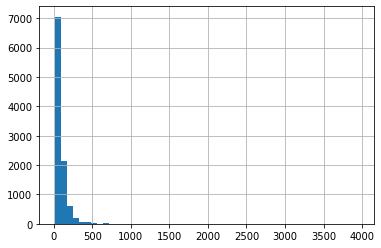

In [ ]:
for percentile in [50, 75, 90, 95, 98, 99, 100]:
    print(percentile, np.percentile(df_train['length'], percentile))
    
df_train['length'].hist(bins=50);

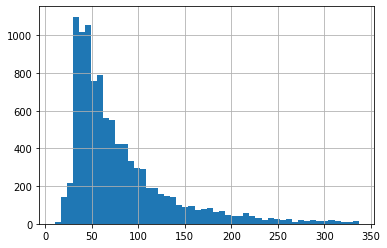

In [ ]:
df_train['length'][df_train['length'] < np.percentile(df_train['length'], 98)].hist(bins=50);

In [ ]:
df_train.groupby('rate')['length'].mean()

rate
0    112.876471
1     85.613848
Name: length, dtype: float64

### liczba słów w tekście

In [ ]:
df_train['word_counts'] = df_train['description'].str.split().str.len()

50 9.0
75 14.0
90 25.0
95 34.0
98 53.0
99 69.01000000000022
100 558.0


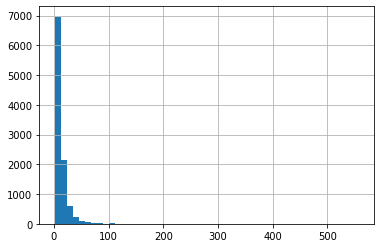

In [ ]:
for percentile in [50, 75, 90, 95, 98, 99, 100]:
    print(percentile, np.percentile(df_train['word_counts'], percentile))
    
df_train['word_counts'].hist(bins=50);

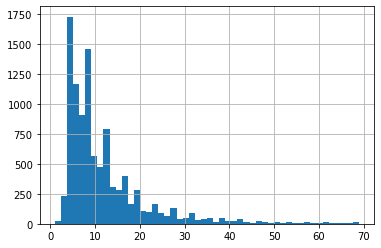

In [ ]:
df_train['word_counts'][df_train['word_counts'] < np.percentile(df_train['word_counts'], 99)].hist(bins=50);

In [ ]:
df_train.groupby('rate')['word_counts'].mean()

rate
0    18.506373
1    11.887132
Name: word_counts, dtype: float64

### liczba znaków na słowo

In [ ]:
df_train['characters_per_word'] = df_train['length'] / df_train['word_counts']

50 7.072077922077922
75 8.0
90 8.900909090909096
95 9.75
98 10.75
99 11.666666666666666
100 37.0


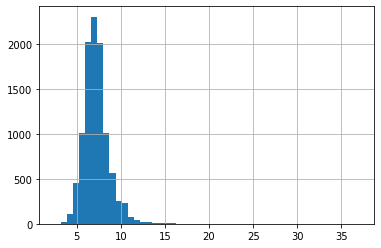

In [ ]:
for percentile in [50, 75, 90, 95, 98, 99, 100]:
    print(percentile, np.percentile(df_train['characters_per_word'], percentile))
    
df_train['characters_per_word'].hist(bins=50);

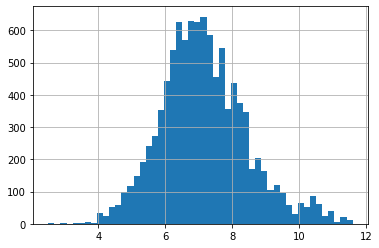

In [ ]:
df_train['characters_per_word'][df_train['characters_per_word'] < np.percentile(df_train['characters_per_word'], 99)].hist(bins=50);

In [ ]:
df_train.groupby('rate')['characters_per_word'].mean()

rate
0    6.012247
1    7.536468
Name: characters_per_word, dtype: float64

### Najczęstsze słowa

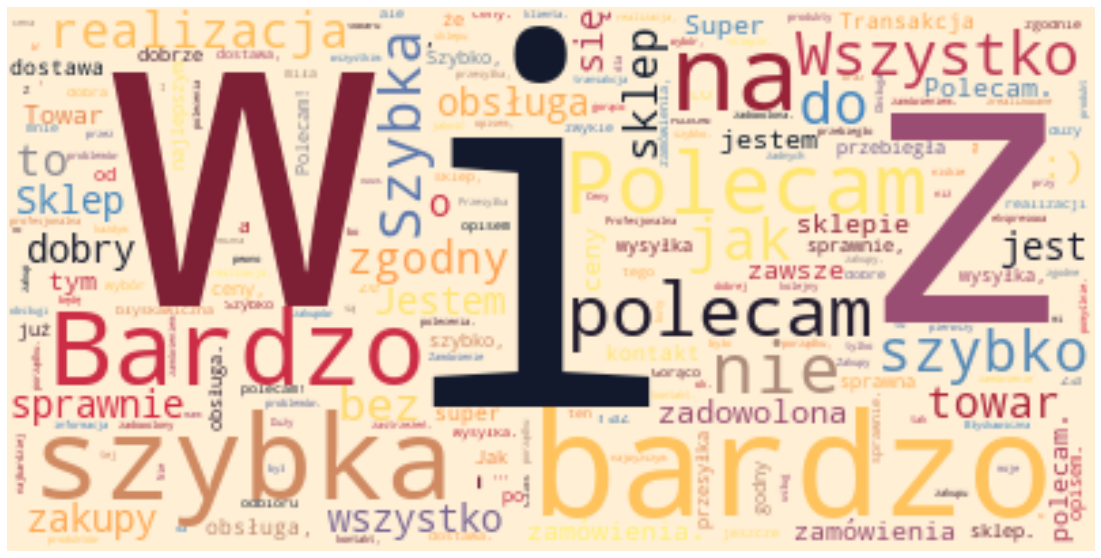

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 1 ]["description"])

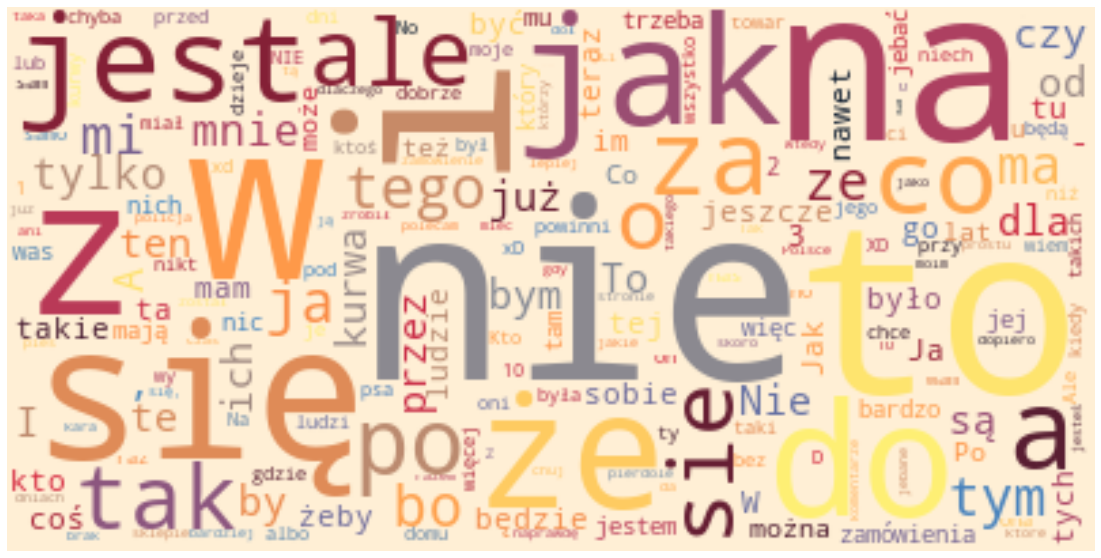

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 0 ]["description"])

In [ ]:
hero.visualization.top_words(df_train[df_train['rate'] == 0]['description']).head(30)

nie      899
to       855
i        817
w        720
na       656
się      532
z        524
że       372
do       353
jak      331
jest     327
a        283
co       240
za       229
ale      195
po       193
tak      186
sie      179
o        163
tego     150
bo       139
ja       137
tym      128
ma       128
mi       127
ze       125
mnie     125
tylko    120
,        115
ten      110
Name: description, dtype: int64

In [ ]:
custom_pipeline = [hero.preprocessing.fillna, hero.preprocessing.lowercase, hero.preprocessing.remove_whitespace,
                  hero.preprocessing.remove_punctuation]

df_train["clean_text"] = hero.preprocessing.clean(df_train["description"], custom_pipeline)
df_test["clean_text"] = hero.preprocessing.clean(df_test["description"], custom_pipeline)

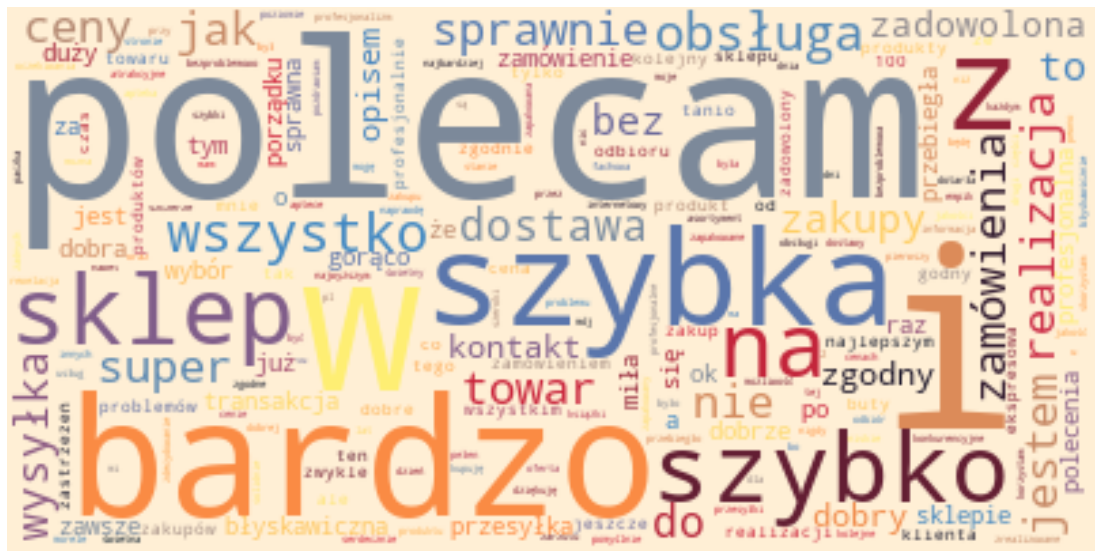

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 1 ]["clean_text"])

In [ ]:
hero.visualization.top_words(df_train[df_train['rate'] == 1]['clean_text']).head(30)

i             3692
polecam       3539
w             2761
bardzo        2754
szybka        2219
z             2179
szybko        1466
sklep         1414
na            1283
wszystko      1230
obsługa       1079
sprawnie       903
jak            890
towar          885
nie            875
realizacja     870
ceny           860
zamówienia     827
super          819
jestem         817
wysyłka        739
dostawa        725
do             690
zakupy         621
bez            613
to             607
zadowolona     568
dobry          518
kontakt        517
zgodny         501
Name: clean_text, dtype: int64

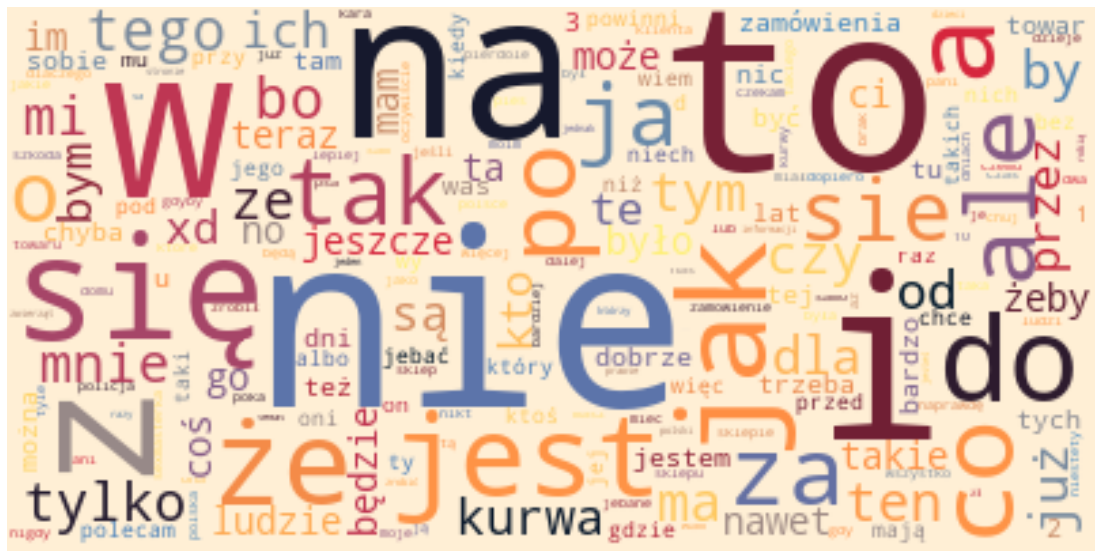

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 0 ]["clean_text"])

In [ ]:
hero.visualization.top_words(df_train[df_train['rate'] == 0]['clean_text']).head(30)

nie      1033
to        969
i         893
w         779
na        703
z         545
się       542
jak       395
do        383
że        381
a         359
jest      343
co        293
za        249
po        243
ale       242
tak       218
ja        198
sie       187
o         184
tego      156
bo        153
ze        140
tym       134
mi        133
ma        133
mnie      132
tylko     130
ten       128
czy       125
Name: clean_text, dtype: int64

In [ ]:
nlp = pl_core_news_sm.load()

In [ ]:
stop_words = nlp.Defaults.stop_words
stop_words.remove('nie')

In [ ]:
def remove_stop_words(sentence):
    res = []
    for e in sentence.split():
        if e not in stop_words:
            res.append(e)
    return ' '.join(res)

In [ ]:
df_train['clean_text_wtht_stopwords'] = df_train['clean_text'].map(remove_stop_words)
df_test['clean_text_wtht_stopwords'] = df_test['clean_text'].map(remove_stop_words)

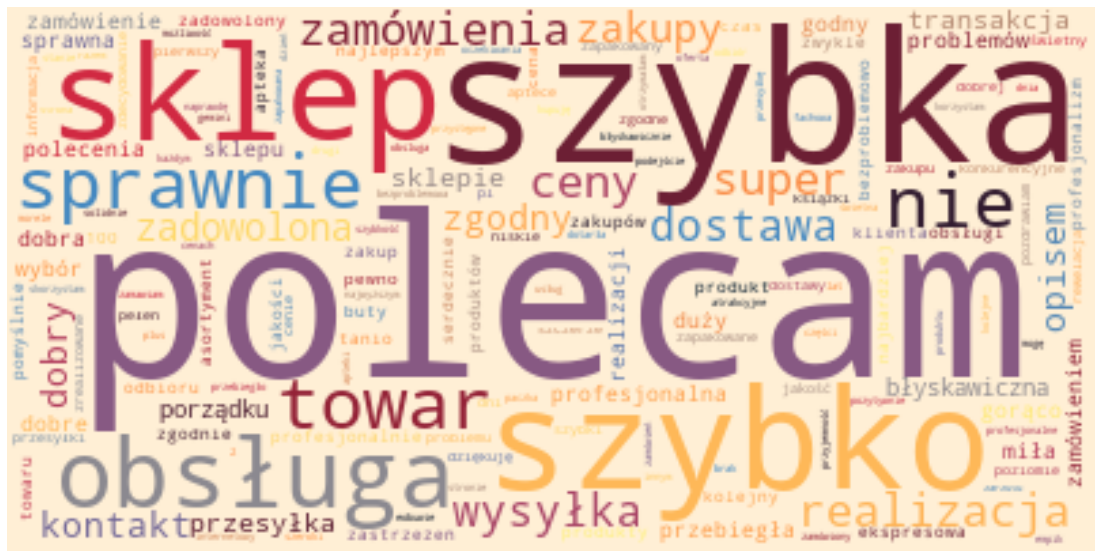

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 1 ]["clean_text_wtht_stopwords"])

In [ ]:
top_pos_text = hero.visualization.top_words(df_train[df_train['rate'] == 1]['clean_text_wtht_stopwords']).head(30)
top_pos_text

polecam          3539
szybka           2219
szybko           1466
sklep            1414
obsługa          1079
sprawnie          903
towar             885
nie               875
realizacja        870
ceny              860
zamówienia        827
super             819
wysyłka           739
dostawa           725
zakupy            621
zadowolona        568
dobry             518
kontakt           517
zgodny            501
transakcja        500
opisem            500
przesyłka         486
sklepie           443
błyskawiczna      362
porządku          327
profesjonalna     308
zamówienie        304
wybór             286
dobra             284
gorąco            281
Name: clean_text_wtht_stopwords, dtype: int64

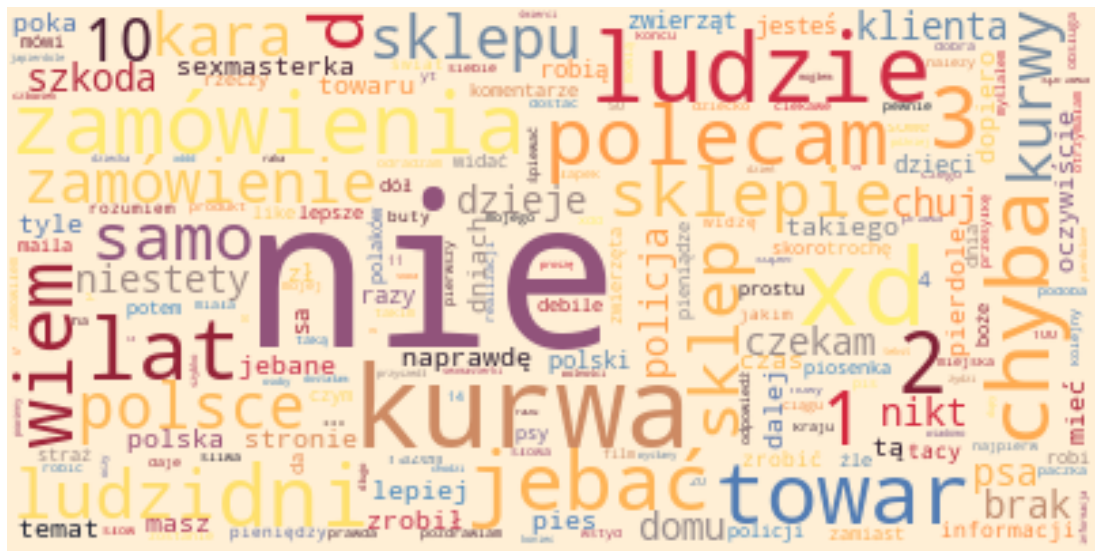

In [ ]:
hero.visualization.wordcloud(df_train[ df_train["rate"] == 0 ]["clean_text_wtht_stopwords"])

In [ ]:
top_neg_text = hero.visualization.top_words(df_train[df_train['rate'] == 0]['clean_text_wtht_stopwords']).head(30)
top_neg_text

nie           1033
kurwa           94
xd              86
ludzie          63
2               52
zamówienia      51
chyba           50
lat             49
3               49
towar           48
dni             46
polecam         43
jebać           42
wiem            40
1               36
d               34
sklepie         33
sklep           33
samo            33
ludzi           32
10              31
sklepu          31
polsce          31
zamówienie      31
kurwy           30
kara            29
psa             28
domu            28
czekam          28
niestety        28
Name: clean_text_wtht_stopwords, dtype: int64

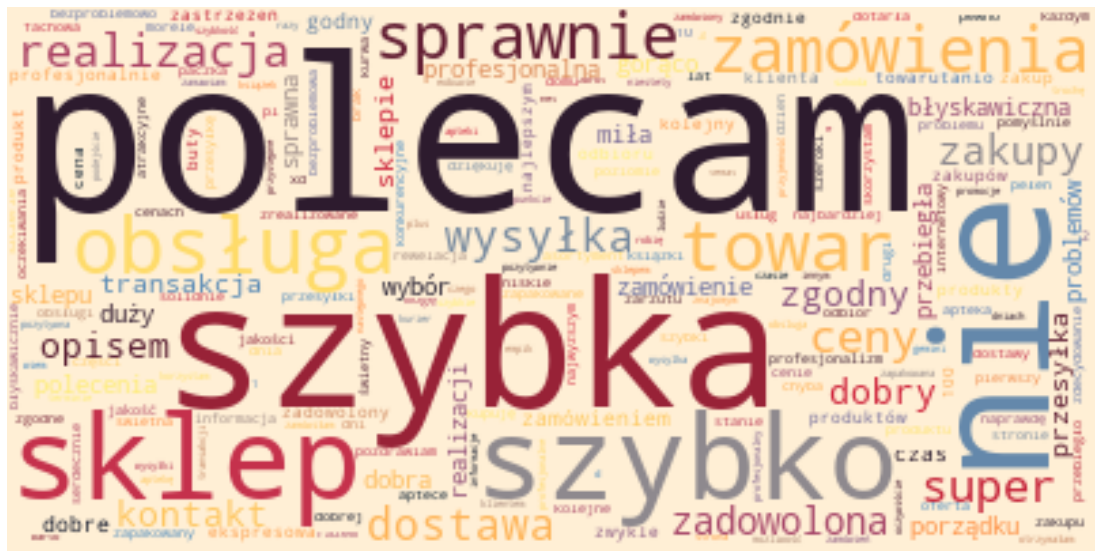

In [ ]:
hero.visualization.wordcloud(df_train["clean_text_wtht_stopwords"])

In [ ]:
top_all_text = hero.visualization.top_words(df_train['clean_text_wtht_stopwords']).head(30)
top_all_text

polecam          3582
szybka           2222
nie              1908
szybko           1478
sklep            1447
obsługa          1092
towar             933
sprawnie          904
zamówienia        878
realizacja        874
ceny              865
super             832
wysyłka           744
dostawa           733
zakupy            628
zadowolona        569
kontakt           527
dobry             527
opisem            503
zgodny            501
transakcja        500
przesyłka         494
sklepie           476
błyskawiczna      362
zamówienie        335
porządku          332
profesjonalna     308
dobra             297
wybór             288
gorąco            281
Name: clean_text_wtht_stopwords, dtype: int64

In [ ]:
set(top_neg_text.index) - set(top_all_text.index)

{'1',
 '10',
 '2',
 '3',
 'chyba',
 'czekam',
 'd',
 'dni',
 'domu',
 'jebać',
 'kara',
 'kurwa',
 'kurwy',
 'lat',
 'ludzi',
 'ludzie',
 'niestety',
 'polsce',
 'psa',
 'samo',
 'sklepu',
 'wiem',
 'xd'}

In [ ]:
set(top_neg_text.index) - set(top_pos_text.index)

{'1',
 '10',
 '2',
 '3',
 'chyba',
 'czekam',
 'd',
 'dni',
 'domu',
 'jebać',
 'kara',
 'kurwa',
 'kurwy',
 'lat',
 'ludzi',
 'ludzie',
 'niestety',
 'polsce',
 'psa',
 'samo',
 'sklepu',
 'wiem',
 'xd'}

In [ ]:
set(top_pos_text.index) - set(top_all_text.index)

set()

In [ ]:
set(top_pos_text.index) - set(top_neg_text.index)

{'błyskawiczna',
 'ceny',
 'dobra',
 'dobry',
 'dostawa',
 'gorąco',
 'kontakt',
 'obsługa',
 'opisem',
 'porządku',
 'profesjonalna',
 'przesyłka',
 'realizacja',
 'sprawnie',
 'super',
 'szybka',
 'szybko',
 'transakcja',
 'wybór',
 'wysyłka',
 'zadowolona',
 'zakupy',
 'zgodny'}

In [ ]:
set(top_all_text.index) - set(top_pos_text.index) - set(top_neg_text.index)

set()

In [ ]:
set(top_neg_text.index) - set(top_pos_text.index) - set(top_all_text.index)

{'1',
 '10',
 '2',
 '3',
 'chyba',
 'czekam',
 'd',
 'dni',
 'domu',
 'jebać',
 'kara',
 'kurwa',
 'kurwy',
 'lat',
 'ludzi',
 'ludzie',
 'niestety',
 'polsce',
 'psa',
 'samo',
 'sklepu',
 'wiem',
 'xd'}

In [ ]:
set(top_pos_text.index) - set(top_neg_text.index) - set(top_all_text.index)

set()

In [ ]:
set(top_pos_text.index).intersection(set(top_neg_text.index))

{'nie', 'polecam', 'sklep', 'sklepie', 'towar', 'zamówienia', 'zamówienie'}

## Topic modeling

In [ ]:
text = df_train['clean_text_wtht_stopwords']

In [ ]:
processed_docs = text.map(simple_preprocess)

In [ ]:
vocab = gensim.corpora.Dictionary(processed_docs)
len(vocab)

16366

In [ ]:
vocab.filter_extremes(no_below=2, no_above=0.50)
len(vocab)

5569

In [ ]:
bow_corpus = [vocab.doc2bow(doc) for doc in processed_docs]

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
%time lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=vocab, passes=2, workers=10, random_state=0)

In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.019*"polecam" + 0.016*"szybko" + 0.015*"sprawnie" + 0.013*"profesjonalna" + 0.013*"obsługa" + 0.011*"super" + 0.011*"nie" + 0.010*"transakcja" + 0.009*"szybka" + 0.008*"sklep"
Topic: 1 
Words: 0.024*"szybka" + 0.020*"realizacja" + 0.018*"polecam" + 0.015*"zamówienia" + 0.013*"sklep" + 0.012*"dobry" + 0.012*"ceny" + 0.011*"dostawa" + 0.011*"obsługa" + 0.010*"szybko"
Topic: 2 
Words: 0.009*"polecam" + 0.008*"nie" + 0.008*"szybka" + 0.008*"super" + 0.008*"sklep" + 0.006*"ceny" + 0.006*"wysyłka" + 0.006*"zakupy" + 0.006*"dostawa" + 0.005*"obsługa"
Topic: 3 
Words: 0.016*"porządku" + 0.012*"szybko" + 0.012*"zadowolona" + 0.012*"najlepszym" + 0.011*"sprawnie" + 0.011*"polecam" + 0.010*"towar" + 0.010*"szybka" + 0.010*"zgodny" + 0.009*"opisem"


In [ ]:
vis_data = gensimvis.prepare(lda_model_tfidf, corpus_tfidf, vocab, sort_topics=False)
pyLDAvis.display(vis_data)

## Klasyfikator sentymentu

In [ ]:
df_train.head()

index  ...                          clean_text_wtht_stopwords
0  500132  ...                  polecam szybko solidnie problemów
1  709189  ...     super ekspresowa przesylka towar zgodny opisem
2  329199  ...  profesjonalna obsługa szybka dostawa najbardzi...
3  920006  ...  radzę przestańcie śpiewać ludzie uważają glono...
4  325795  ...  szybka realizacja zamówienia ceny niższe aptekach

[5 rows x 8 columns]

In [ ]:
nlp = spacy.load("pl_core_news_sm")
def my_tokenizer(doc):
    nlp_doc = nlp(doc, disable=['tagger', 'parser', 'ner'])
    return " ".join([token.lemma_.lower() if token.lemma_ != "-PRON-" else token.text.lower()  for token in nlp(doc) ])

In [ ]:
%%time
df_train['spacy_tokens'] = df_train['clean_text'].map(my_tokenizer)

CPU times: user 1min 45s, sys: 45.3 ms, total: 1min 45s
Wall time: 1min 45s


In [ ]:
def get_top_words(df, topn, feat_text='clean_text'):
    ctr = Counter()
    df[feat_text].str.lower().str.split(" ").map(ctr.update)
    return { x[0] for x in ctr.most_common(topn) }

In [ ]:
topn=600
common_words = get_top_words(df_train, topn)
positive_words = get_top_words(df_train[ df_train['rate'] == 1 ], topn, 'spacy_tokens')
negative_words = get_top_words(df_train[ df_train['rate'] == 0 ], topn, 'spacy_tokens')

words = common_words | positive_words | negative_words
vocab = {}
for word in words:
    vocab[word] = len(vocab)

len(vocab)

1176

In [ ]:
df_train['tokens'] = df_train['spacy_tokens'].map(lambda doc: [vocab[w] for w in doc.split(" ") if w in vocab])

In [ ]:
X = sequence.pad_sequences(df_train['tokens'], maxlen=20, padding='post', truncating='post')

In [ ]:
y = df_train['rate']

In [ ]:
X.shape

(10200, 20)

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

x_trains = []
x_tests = []
y_trains = []
y_tests = []

for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
    print("Fold " + str(index+1))
    xtrain, xval = X[train_indices], X[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]

    print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)
    x_trains.append(xtrain)
    x_tests.append(xval)
    y_trains.append(ytrain)
    y_tests.append(yval)

Fold 1
(6800, 20) (6800,) (3400, 20) (3400,)
Fold 2
(6800, 20) (6800,) (3400, 20) (3400,)
Fold 3
(6800, 20) (6800,) (3400, 20) (3400,)


In [ ]:
def run_two_bidirectional_layers_lstm_with_dropout_model_val(X, y, xval, yval, max_top_words=300, max_doc_length=20, embedding_vecor_length=32, epochs_num=5):
    model = Sequential([
        Embedding(max_top_words, embedding_vecor_length, input_length=max_doc_length),
        Dropout(0.8),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(1, activation='sigmoid')

    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    
    hist = model.fit(
        X, y, 
        epochs=epochs_num, batch_size=256,
        validation_data=(xval, yval),
        callbacks=[PlotLossesKeras()],
        verbose=0
    )
    
    results = {'model': 'two_bidirectional_layers_lstm_32_dropout', 'max_top_words': max_top_words, 'max_doc_length': max_doc_length,
               'embedding_vecor_length': embedding_vecor_length, 'loss': hist.history['loss'][-1],
               'val_loss': hist.history['val_loss'][-1], 'accuracy': hist.history['accuracy'][-1], 'val_accuracy': hist.history['val_accuracy'][-1]}
    
    return results, model

In [ ]:
max_top_words=1176
max_sentence_length=20
embedding_vecor_length=30

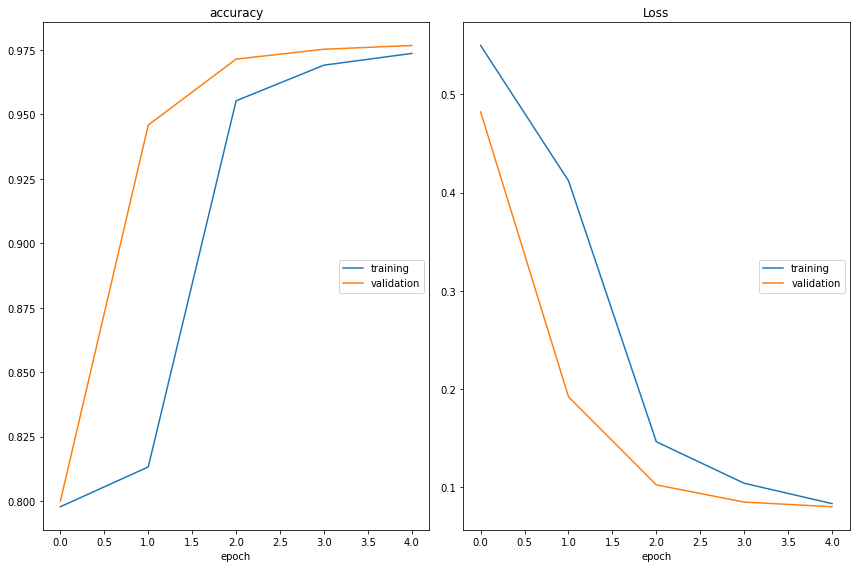

accuracy
	training         	 (min:    0.798, max:    0.974, cur:    0.974)
	validation       	 (min:    0.800, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.083, max:    0.550, cur:    0.083)
	validation       	 (min:    0.080, max:    0.482, cur:    0.080)
CPU times: user 11.5 s, sys: 1.67 s, total: 13.2 s
Wall time: 20.9 s


In [ ]:
%time results, model = run_two_bidirectional_layers_lstm_with_dropout_model_val(x_trains[0], y_trains[0], x_tests[0], y_tests[0], max_top_words, max_sentence_length, embedding_vecor_length)

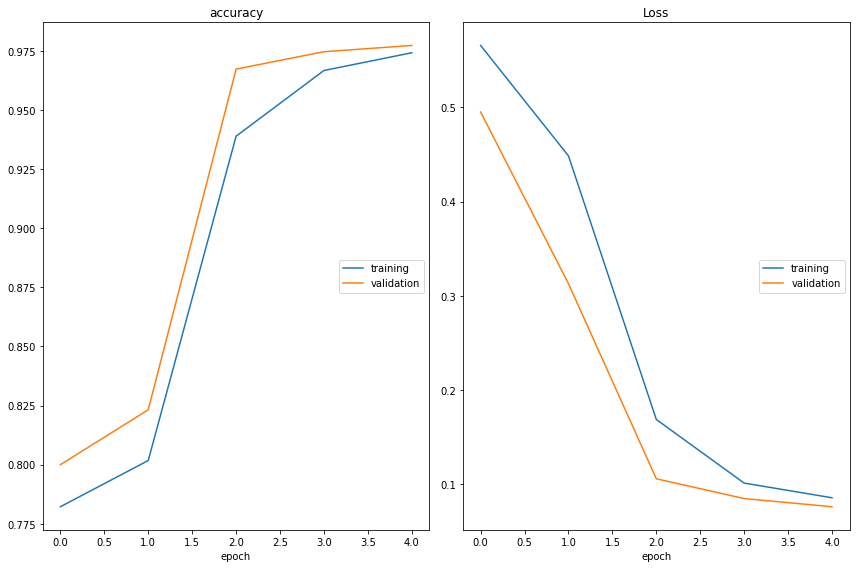

accuracy
	training         	 (min:    0.782, max:    0.974, cur:    0.974)
	validation       	 (min:    0.800, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.086, max:    0.566, cur:    0.086)
	validation       	 (min:    0.076, max:    0.495, cur:    0.076)
CPU times: user 11.1 s, sys: 1.09 s, total: 12.2 s
Wall time: 11 s


In [ ]:
%time results, model = run_two_bidirectional_layers_lstm_with_dropout_model_val(x_trains[1], y_trains[1], x_tests[1], y_tests[1], max_top_words, max_sentence_length, embedding_vecor_length)

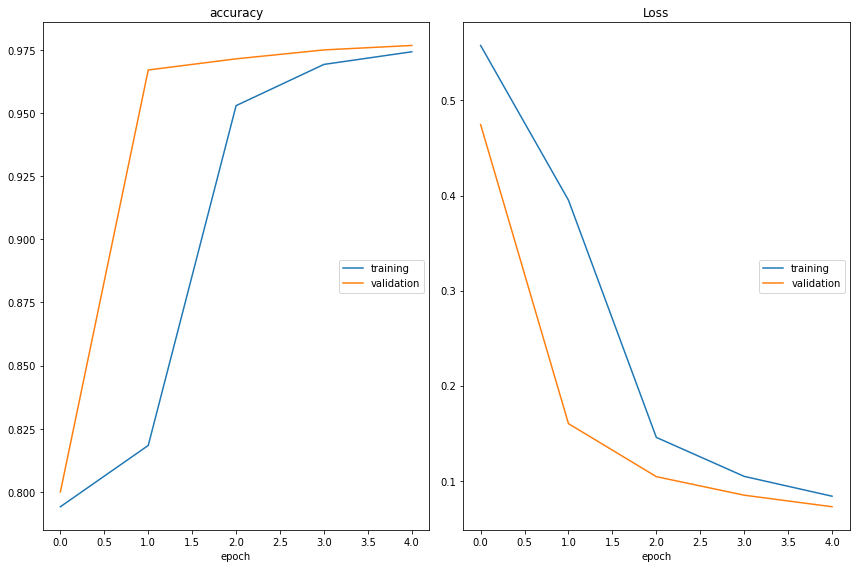

accuracy
	training         	 (min:    0.794, max:    0.974, cur:    0.974)
	validation       	 (min:    0.800, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.084, max:    0.558, cur:    0.084)
	validation       	 (min:    0.073, max:    0.475, cur:    0.073)
CPU times: user 10.8 s, sys: 959 ms, total: 11.8 s
Wall time: 10.5 s


In [ ]:
%time results, model = run_two_bidirectional_layers_lstm_with_dropout_model_val(x_trains[2], y_trains[2], x_tests[2], y_tests[2], max_top_words, max_sentence_length, embedding_vecor_length)

In [ ]:
def run_two_bidirectional_layers_lstm_with_dropout_model(X, y, max_top_words=300, max_doc_length=20, embedding_vecor_length=32, epochs_num=5):
    model = Sequential([
        Embedding(max_top_words, embedding_vecor_length, input_length=max_doc_length),
        Dropout(0.8),
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(1, activation='sigmoid')

    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    
    hist = model.fit(
        X, y, 
        epochs=epochs_num, batch_size=256,
        validation_split=0.1,
        callbacks=[PlotLossesKeras()],
        verbose=0
    )
    
    results = {'model': 'two_bidirectional_layers_lstm_32_dropout', 'max_top_words': max_top_words, 'max_doc_length': max_doc_length,
               'embedding_vecor_length': embedding_vecor_length, 'loss': hist.history['loss'][-1],
               'val_loss': hist.history['val_loss'][-1], 'accuracy': hist.history['accuracy'][-1], 'val_accuracy': hist.history['val_accuracy'][-1]}
    
    return results, model

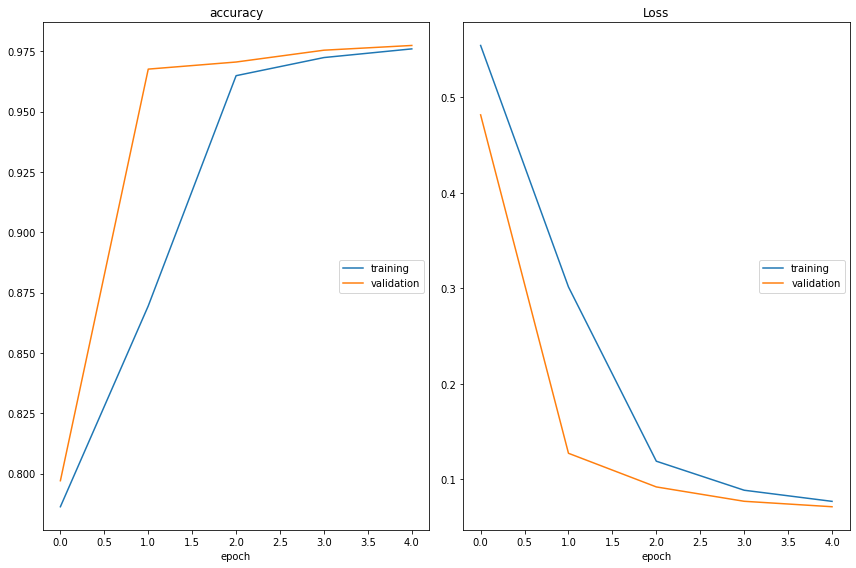

accuracy
	training         	 (min:    0.786, max:    0.976, cur:    0.976)
	validation       	 (min:    0.797, max:    0.977, cur:    0.977)
Loss
	training         	 (min:    0.077, max:    0.554, cur:    0.077)
	validation       	 (min:    0.071, max:    0.482, cur:    0.071)
CPU times: user 11 s, sys: 964 ms, total: 12 s
Wall time: 10.7 s


In [ ]:
max_top_words=1176
max_sentence_length=20
embedding_vecor_length=30

%time results, model = run_two_bidirectional_layers_lstm_with_dropout_model(X, y, max_top_words, max_sentence_length, embedding_vecor_length)

In [ ]:
model.save('./drive/My Drive/Colab Notebooks/pko/model_11.h5')

### Ewaluacja na zbiorze testowym

In [ ]:
%%time
df_test['spacy_tokens'] = df_test['clean_text'].map(my_tokenizer)

CPU times: user 18.5 s, sys: 37.1 ms, total: 18.5 s
Wall time: 18.5 s


In [ ]:
df_test['tokens'] = df_test['spacy_tokens'].map(lambda doc: [vocab[w] for w in doc.split(" ") if w in vocab])

In [ ]:
X_test = sequence.pad_sequences(df_test['tokens'], maxlen=20, padding='post', truncating='post')
y_test = df_test['rate']
X_test.shape

(1800, 20)

In [ ]:
test_scores = model.evaluate(X_test, y_test)
test_scores

57/57 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.9767


[0.07549712061882019, 0.9766666889190674]

In [ ]:
f1 = f1_score(df_test['rate'], df_test['y_pred'], average='weighted')
print("F1 score: ", f1)

F1 score:  0.9765678981605405


## macierz pomyłek

In [ ]:
df_test['y_pred'] = model.predict(X_test)

In [ ]:
df_test['y_pred'] = df_test['y_pred'].round().astype(int)

In [ ]:
df_test[df_test['rate'] != df_test['y_pred']].shape

(42, 9)

In [ ]:
df_test[df_test['rate'] != df_test['y_pred']]['description'].values

array(['Gdzie byl Boniek W szafie jak zwykle rudy oszust',
       'Niestety,  jedną pozycję z listy kilkunastu wysłano nieprawidłowo, w związku z czym zmuszona byłam  złożyć reklamację. poza tym w porządku.',
       '0138 Najwyższy czas, żebyście wypierdoliły z mediów',
       'Jesli nie zalezy Ci na czasie polecam.',
       'Proszę o więcej reklamówek, dostałkam jedną małą próbkę mikrozłuszczającego żelu do mycia twarzy.\r\r\r\n Z poważaniem Stanisława.',
       'Prawie całego kompa u nich kupiłem po za buda (trzymam starą bo mi szkoda $$ na nowe)\r\r\r\nJako stały klient polecam od złożenia zamówienia do odbioru minęły może 2 dni \r\r\r\nProfesjonalne podejście i jakość idąca w parze z atrakcyjnymi cenami',
       'Odradzam zakupy w tym sklepie. Termin dostawy jest niezgodny z podanym na stronie sklepu. Codziennie go zmieniają. Minął już ponad tydzień od planowej daty dostawy. Ciągle jest jakiś problem i przesyłka nie jest wysyłana. Podejście do klienta jest po prostu żenujące.',
   

In [ ]:
df_test[(df_test['rate'] != df_test['y_pred']) & (df_test['rate'] == 0)]['description'].values

array(['Gdzie byl Boniek W szafie jak zwykle rudy oszust',
       '0138 Najwyższy czas, żebyście wypierdoliły z mediów',
       'Odradzam zakupy w tym sklepie. Termin dostawy jest niezgodny z podanym na stronie sklepu. Codziennie go zmieniają. Minął już ponad tydzień od planowej daty dostawy. Ciągle jest jakiś problem i przesyłka nie jest wysyłana. Podejście do klienta jest po prostu żenujące.',
       'Zdecydowanie odradzam. Sprzedają rzeczy, których nie posiadają na magazynach i przeciągają termin wysyłki. Od tygodnia dzwoniłam i dowiadywałam się, kiedy otrzymam przesyłkę, ciągle słyszałam , że już jest u nich, że na pewno będzie wysłana w terminie , że będzie wysłana dnia następnego. Koniec końców w momencie gdy miałam dość oczekiwania i zrezygnowałam z zakupu, oni wciąż nie ściągnęli zabawki od dostawcy. Gdyby od razu poinformowali o kłopotach ze zdobyciem zabawki - tak jak robią inne sklepy internetowe - miałabym czas na zakup gdzie indziej. A tak po 8 dniach oczekiwania zostałam 

In [ ]:
df_test[(df_test['rate'] != df_test['y_pred']) & (df_test['rate'] == 1)]['description'].values

array(['Niestety,  jedną pozycję z listy kilkunastu wysłano nieprawidłowo, w związku z czym zmuszona byłam  złożyć reklamację. poza tym w porządku.',
       'Jesli nie zalezy Ci na czasie polecam.',
       'Proszę o więcej reklamówek, dostałkam jedną małą próbkę mikrozłuszczającego żelu do mycia twarzy.\r\r\r\n Z poważaniem Stanisława.',
       'Prawie całego kompa u nich kupiłem po za buda (trzymam starą bo mi szkoda $$ na nowe)\r\r\r\nJako stały klient polecam od złożenia zamówienia do odbioru minęły może 2 dni \r\r\r\nProfesjonalne podejście i jakość idąca w parze z atrakcyjnymi cenami',
       'Nie mają wszystkich książek świata, ale mają ich bardzo dużo. Plus ich punkt odbioru znajduje się zaraz obok mojej pracy, więc dużo tam kupuję. Dostawa zawsze następnego dnia.',
       'Zamówiłem dwie bluzy. Obydwie dotarły. Z niecierpliwością otworzyłem paczkę i co? Jedna była ok a druga krzywo uszyta ( wewnętrzna wyściółka wystaje na prawym ramieniu ) gdzie się podziała kontrola jakości pr

In [ ]:
df_test[df_test['rate'] != df_test['y_pred']]['clean_text'].values

array(['gdzie byl boniek w szafie jak zwykle rudy oszust',
       'niestety  jedną pozycję z listy kilkunastu wysłano nieprawidłowo  w związku z czym zmuszona byłam złożyć reklamację  poza tym w porządku ',
       '0138 najwyższy czas  żebyście wypierdoliły z mediów',
       'jesli nie zalezy ci na czasie polecam ',
       'proszę o więcej reklamówek  dostałkam jedną małą próbkę mikrozłuszczającego żelu do mycia twarzy  z poważaniem stanisława ',
       'prawie całego kompa u nich kupiłem po za buda  trzymam starą bo mi szkoda   na nowe  jako stały klient polecam od złożenia zamówienia do odbioru minęły może 2 dni profesjonalne podejście i jakość idąca w parze z atrakcyjnymi cenami',
       'odradzam zakupy w tym sklepie  termin dostawy jest niezgodny z podanym na stronie sklepu  codziennie go zmieniają  minął już ponad tydzień od planowej daty dostawy  ciągle jest jakiś problem i przesyłka nie jest wysyłana  podejście do klienta jest po prostu żenujące ',
       'zdecydowanie odradzam

In [ ]:
df_test[df_test['rate'] != df_test['y_pred']]['clean_text_wtht_stopwords'].values

array(['boniek szafie zwykle rudy oszust',
       'niestety jedną pozycję listy kilkunastu wysłano nieprawidłowo związku czym zmuszona byłam złożyć reklamację porządku',
       '0138 najwyższy czas żebyście wypierdoliły mediów',
       'nie zalezy czasie polecam',
       'proszę reklamówek dostałkam jedną małą próbkę mikrozłuszczającego żelu mycia twarzy poważaniem stanisława',
       'całego kompa kupiłem buda trzymam starą szkoda nowe stały klient polecam złożenia zamówienia odbioru minęły 2 dni profesjonalne podejście jakość idąca parze atrakcyjnymi cenami',
       'odradzam zakupy sklepie termin dostawy niezgodny podanym stronie sklepu codziennie zmieniają minął tydzień planowej daty dostawy ciągle problem przesyłka nie wysyłana podejście klienta prostu żenujące',
       'zdecydowanie odradzam sprzedają rzeczy nie posiadają magazynach przeciągają termin wysyłki tygodnia dzwoniłam dowiadywałam otrzymam przesyłkę ciągle słyszałam pewno wysłana terminie wysłana dnia następnego koniec 

In [ ]:
conf_mat = confusion_matrix(df_test['rate'], df_test['y_pred'])

In [ ]:
# normalized
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
conf_mat = np.around(conf_mat, decimals=2)

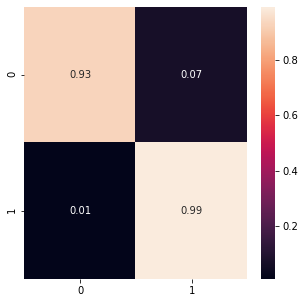

In [ ]:
df_cm = pd.DataFrame(conf_mat)
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

plt.show()